In [2]:
!pip install gymnasium numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.1 MB/s eta 0:00:00


In [12]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [10]:
# Define the neural network for the Q-function
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.model = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state).detach())
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [27]:
# Custom Gymnasium environment with UAV clustering
class UAVClusterEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, n_users=100, area_size=100, n_uavs=5):
        super(UAVClusterEnv, self).__init__()

        self.n_users = n_users
        self.area_size = area_size
        self.n_uavs = n_uavs

        # Define action and observation space
        self.action_space = spaces.Discrete(4)  # Actions: 0: Up, 1: Down, 2: Left, 3: Right
        self.observation_space = spaces.Box(
            low=0, high=area_size, shape=(n_users + n_uavs, 2), dtype=np.float32)

        # Initialize the state
        self.user_state = None
        self.uav_state = None
        self.user_velocity = None
        self.reset()

    def reset(self):
        # Randomly distribute users in the 2D area
        self.user_state = np.random.uniform(0, self.area_size, (self.n_users, 2))

        # Randomly initialize user velocities
        self.user_velocity = np.random.uniform(-1, 1, (self.n_users, 2))

        # Use K-means clustering to find centroids
        kmeans = KMeans(n_clusters=self.n_uavs, n_init=10)
        kmeans.fit(self.user_state)
        self.uav_state = kmeans.cluster_centers_

        return np.vstack((self.user_state, self.uav_state))

    def step(self, action):
        # Move users based on their velocities
        self.user_state += self.user_velocity

        # Check for boundary collisions and update velocities
        for i in range(self.n_users):
            if self.user_state[i, 0] <= 0 or self.user_state[i, 0] >= self.area_size:
                self.user_velocity[i, 0] *= -1
                self.user_velocity[i] = np.random.uniform(-1, 1, 2)
            if self.user_state[i, 1] <= 0 or self.user_state[i, 1] >= self.area_size:
                self.user_velocity[i, 1] *= -1
                self.user_velocity[i] = np.random.uniform(-1, 1, 2)

        # Clip the positions to stay within the area
        self.user_state = np.clip(self.user_state, 0, self.area_size)
        self.uav_state = np.clip(self.uav_state, 0, self.area_size)

        # Update UAV positions based on new user positions (simple static re-clustering for demonstration)
        kmeans = KMeans(n_clusters=self.n_uavs, n_init=10)
        kmeans.fit(self.user_state)
        self.uav_state = kmeans.cluster_centers_

        # Define a dummy reward
        reward = -np.mean(self.user_state)  # Just an example, can be modified

        # Dummy done condition
        done = False

        info = {}

        return np.vstack((self.user_state, self.uav_state)), reward, done, info

    def render(self, mode='human', close=False):
        if mode == 'human':
            # clears the current axes to update the plot instead of creating a new one.
            self.ax.cla()  # Clear the previous plot
            self.ax.scatter(self.user_state[:, 0], self.user_state[:, 1], c='blue', label='Users')
            self.ax.scatter(self.uav_state[:, 0], self.uav_state[:, 1], c='red', marker='x', label='UAVs')
            self.ax.set_xlim(0, self.area_size)
            self.ax.set_ylim(0, self.area_size)
            self.ax.legend()
            self.ax.set_title("UAV and User Distribution")
            plt.pause(0.01)  # Pause to create an animation effect
        else:
            super(UAVClusterEnv, self).render(mode=mode)

    def close(self):
        pass

In [23]:
# Main training loop
def train_dqn(env, agent, episodes=1000):
    for e in range(episodes):
        state = env.reset()
        state = state.flatten()
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.flatten()
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
            agent.replay()
        if e % 10 == 0:
            print(f"Episode: {e}/{episodes}, Epsilon: {agent.epsilon:.2f}")

In [24]:
# Create the environment and DQN agent
env = UAVClusterEnv()
state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

In [25]:
# Train the DQN agent
train_dqn(env, agent)

Episode: 0/1000, Epsilon: 0.11


KeyboardInterrupt: 

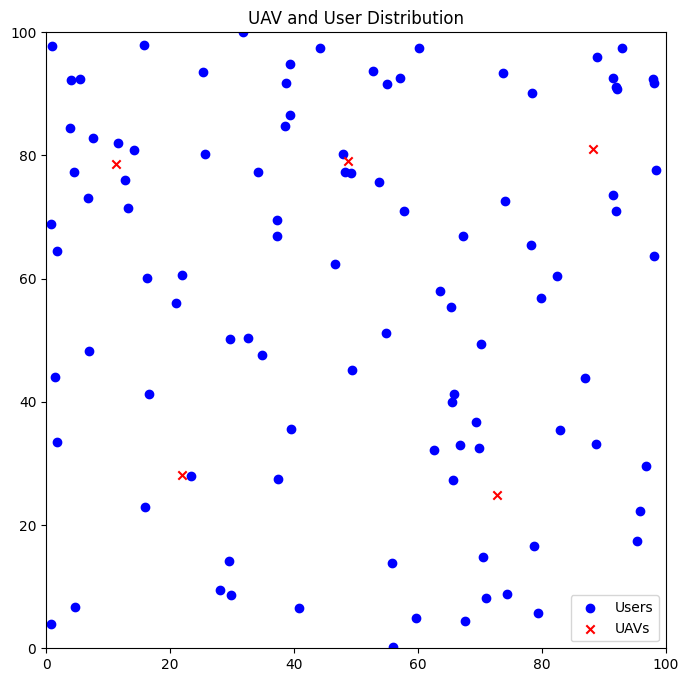

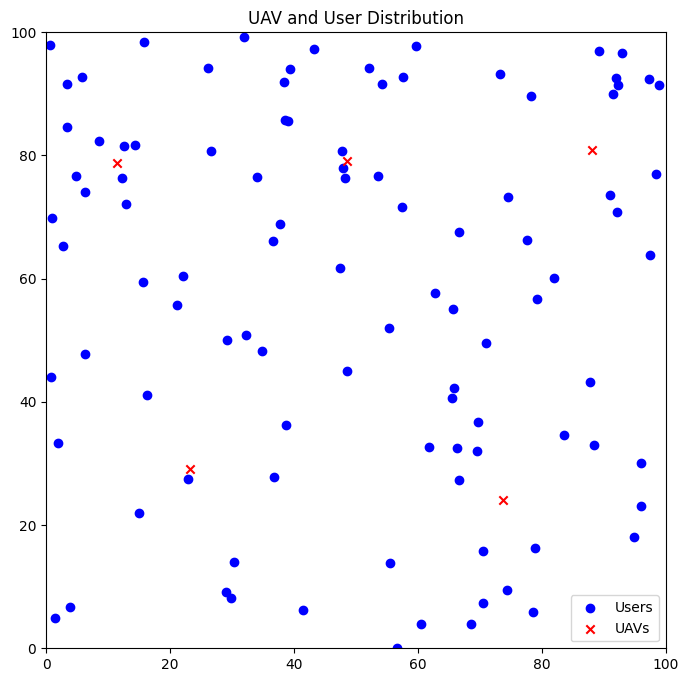

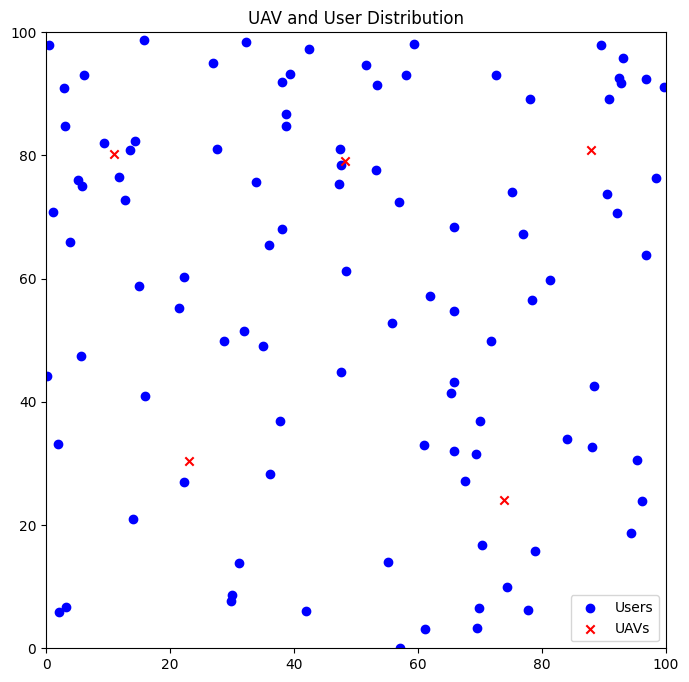

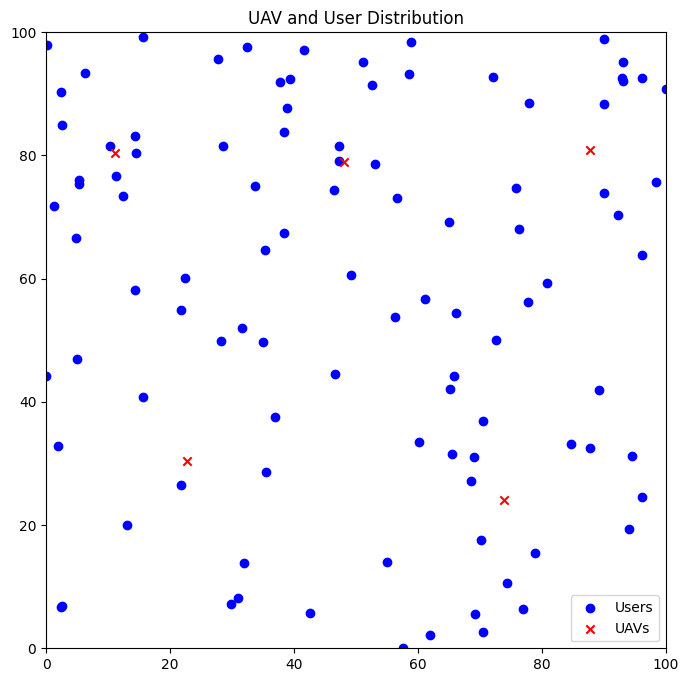

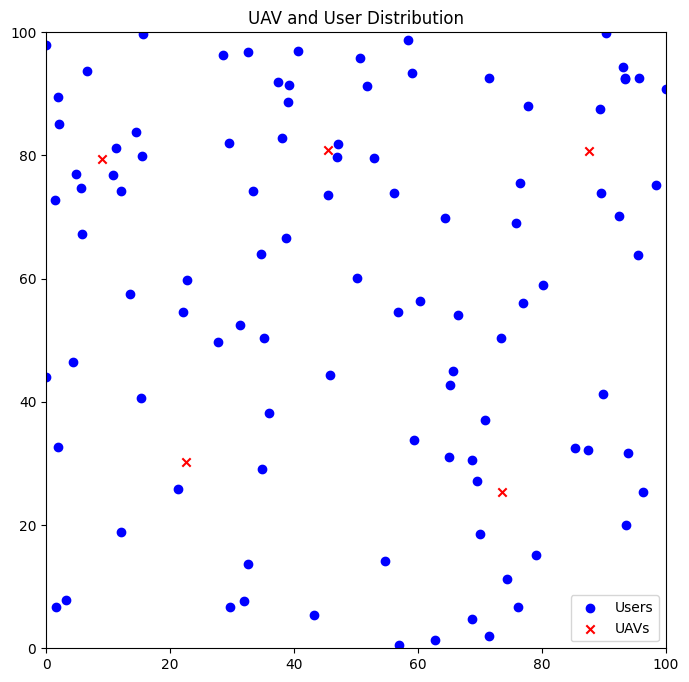

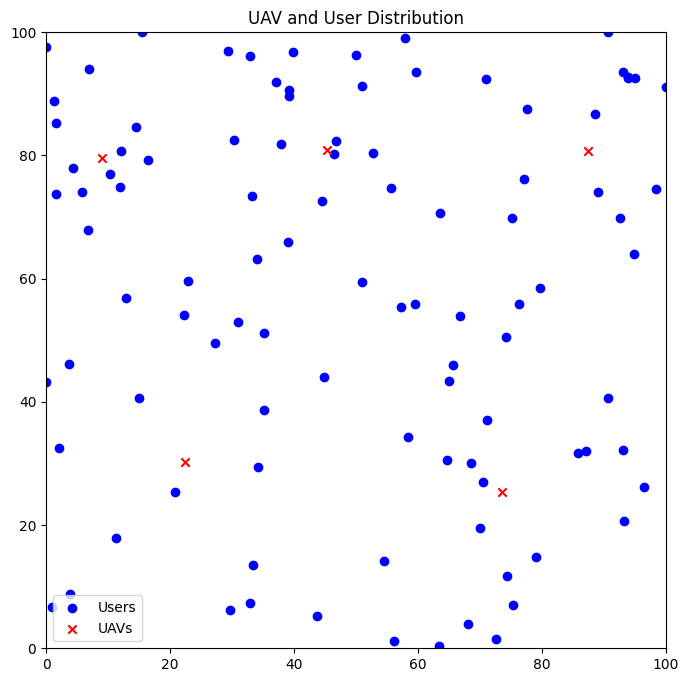

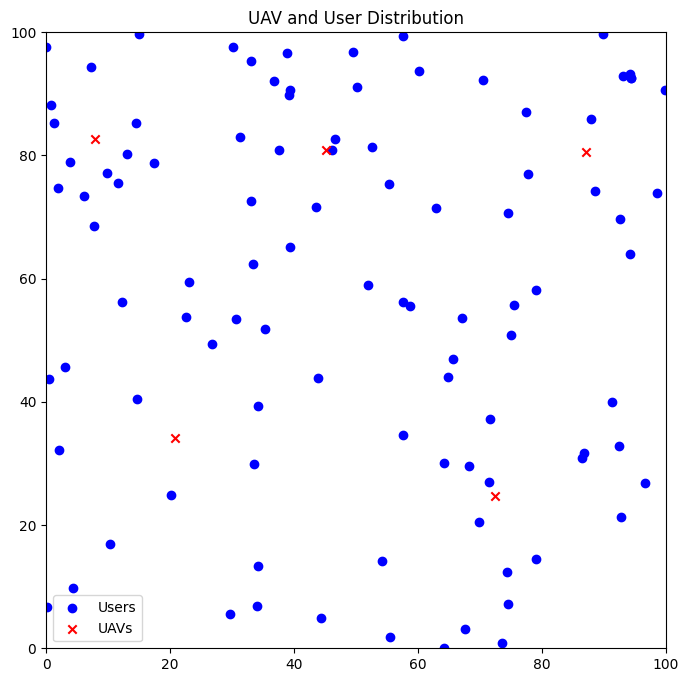

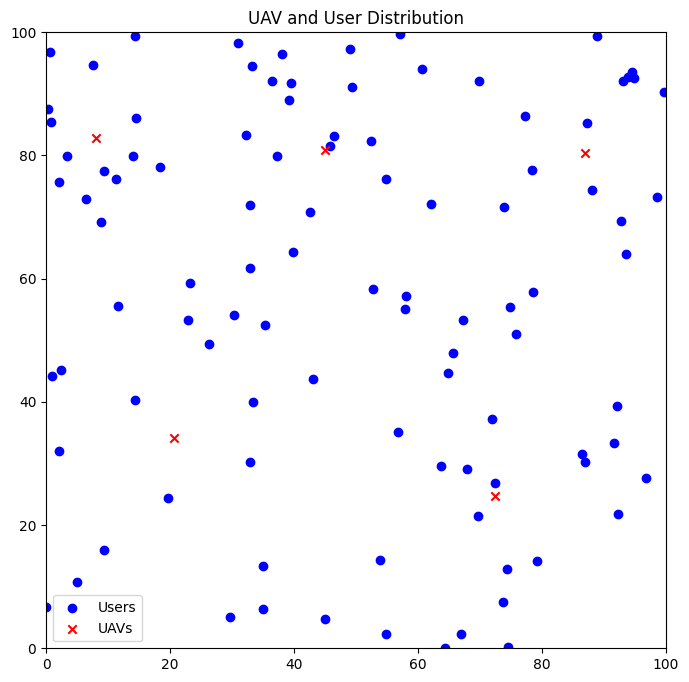

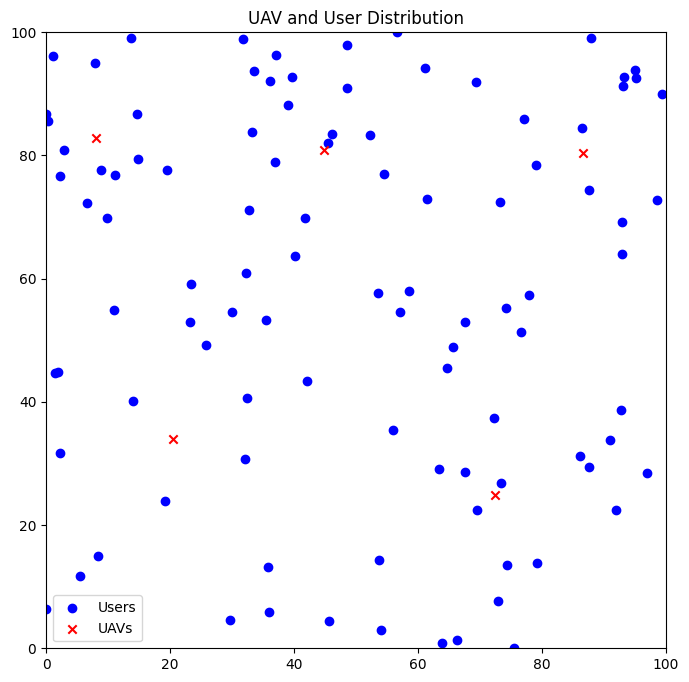

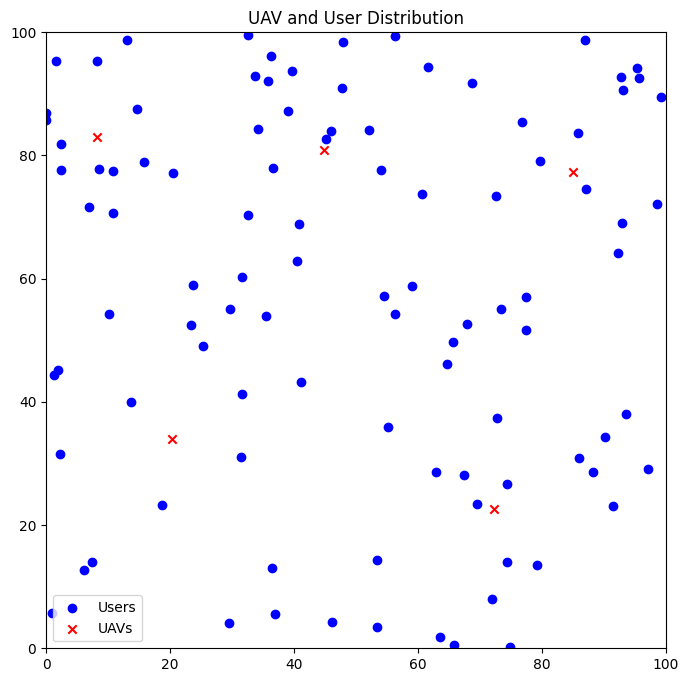

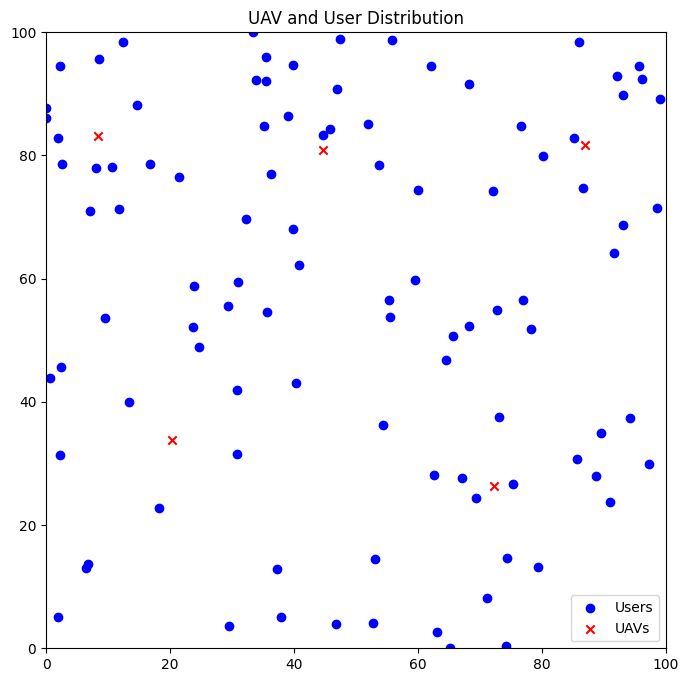

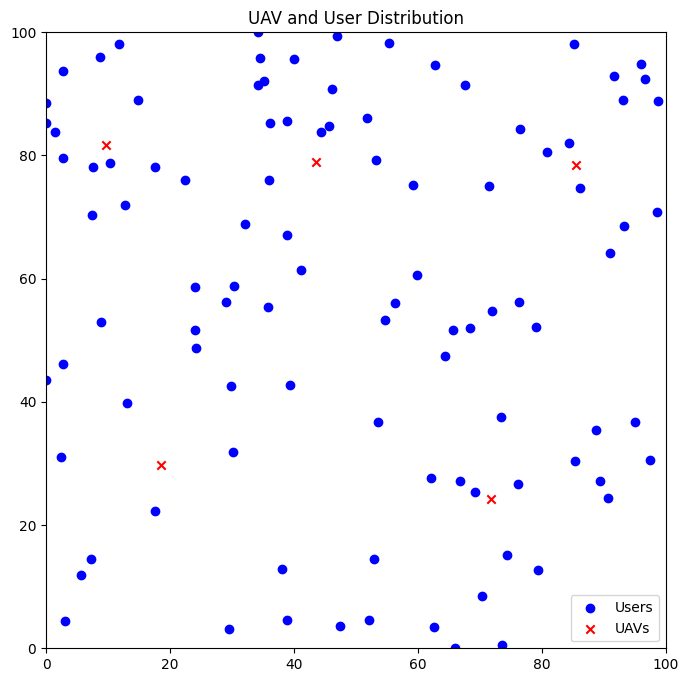

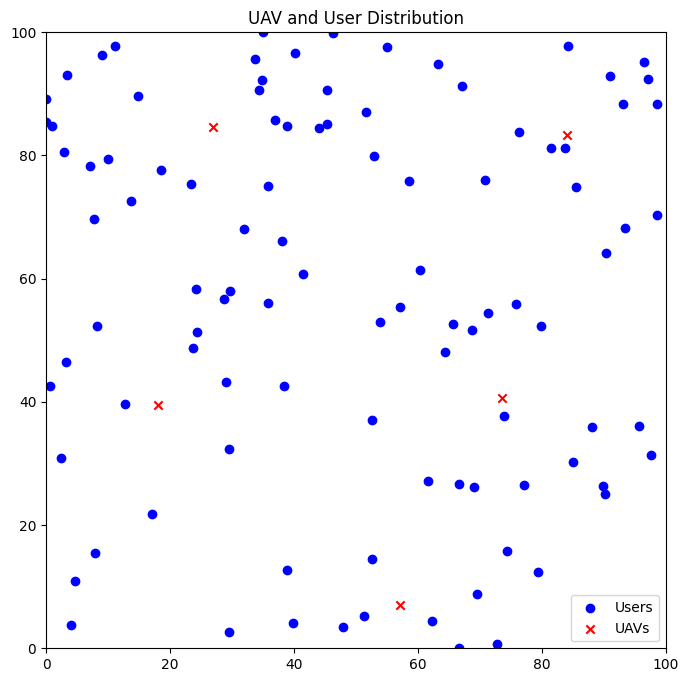

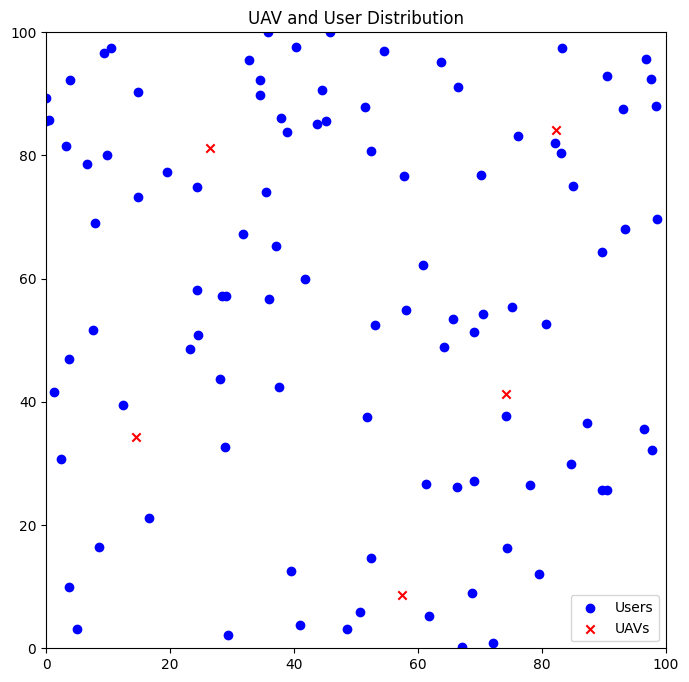

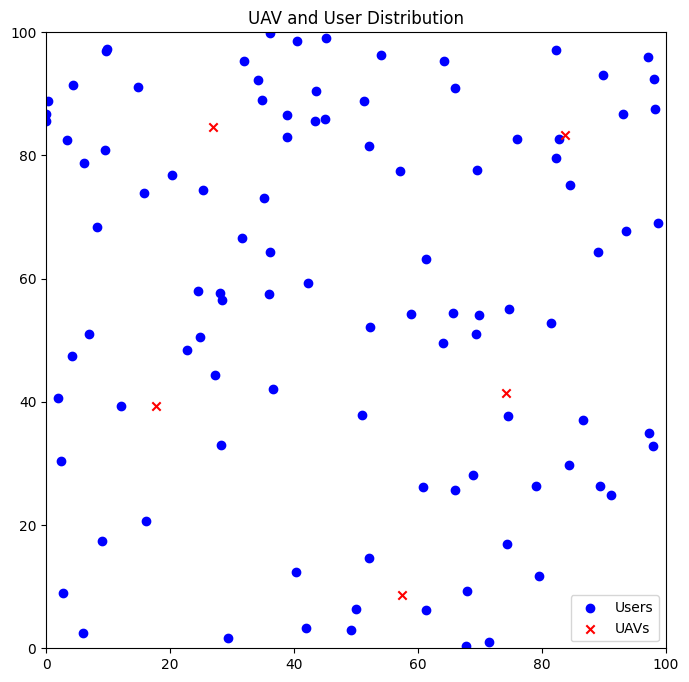

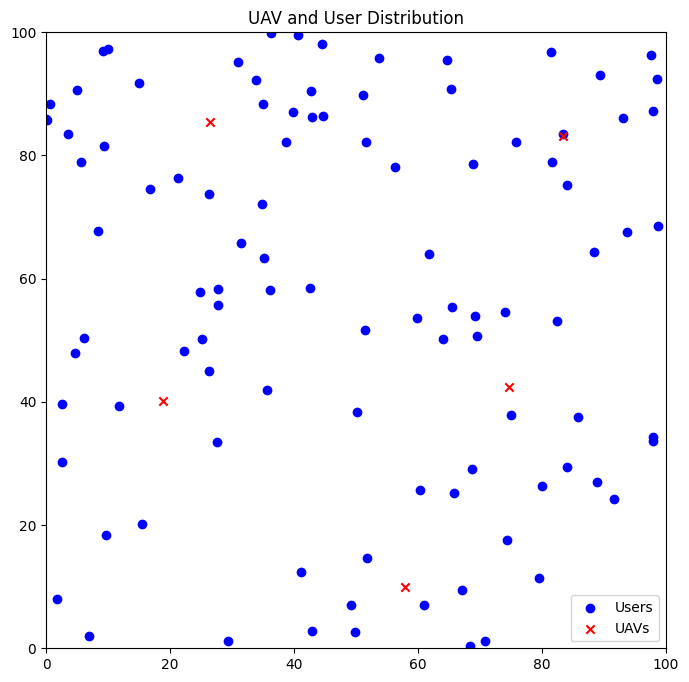

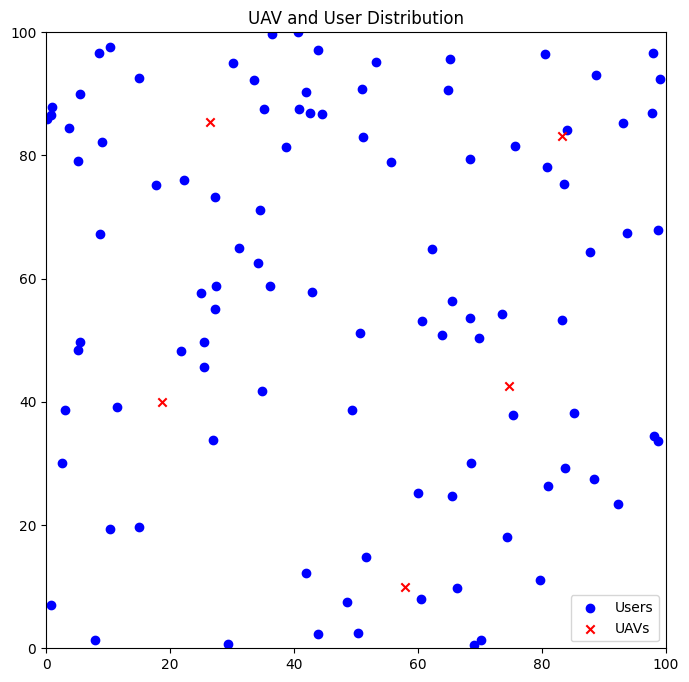

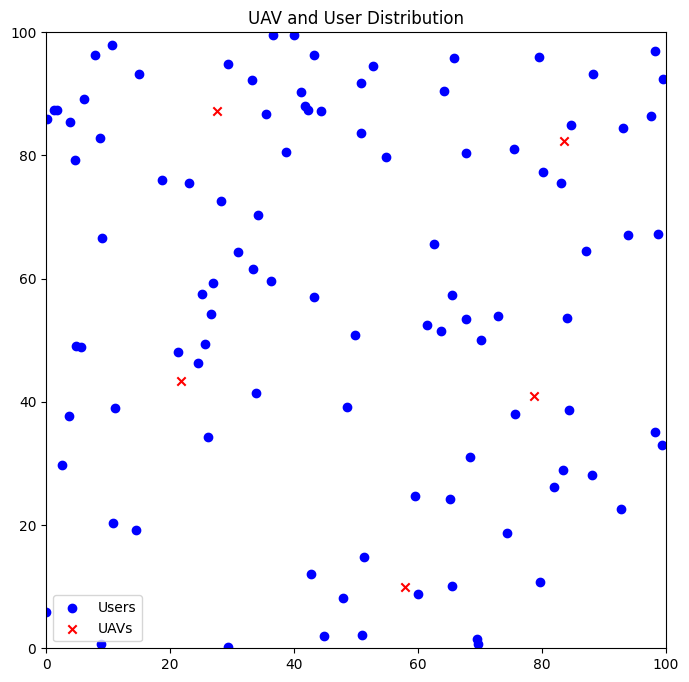

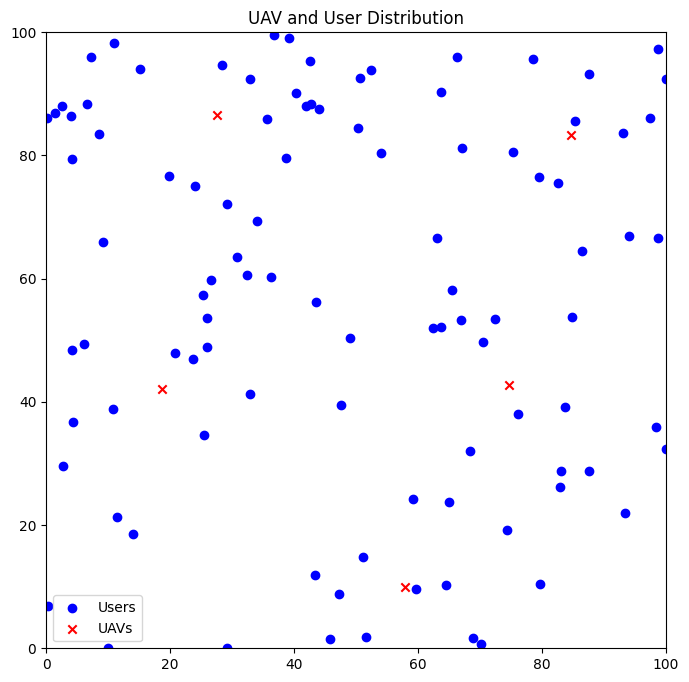

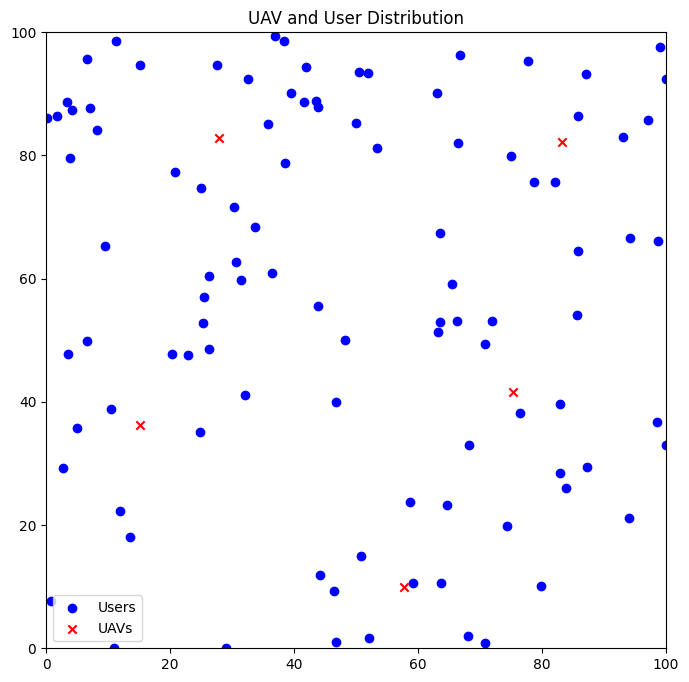

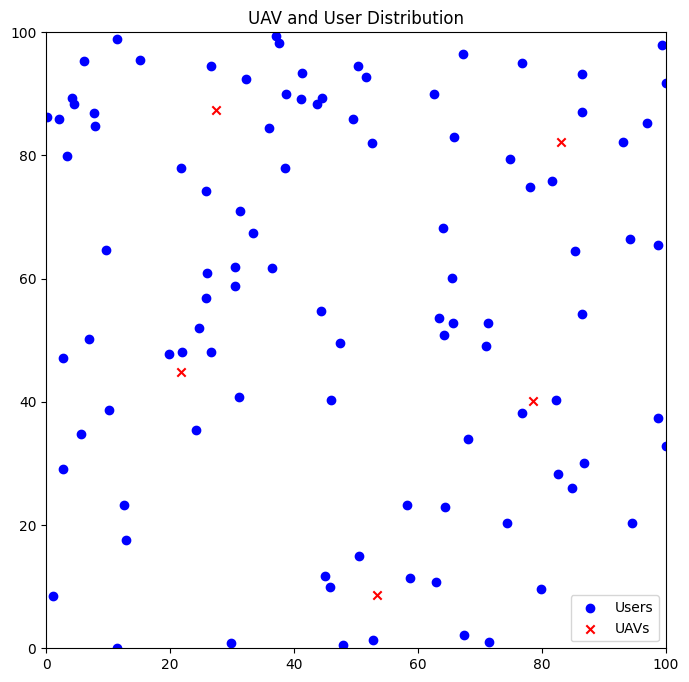

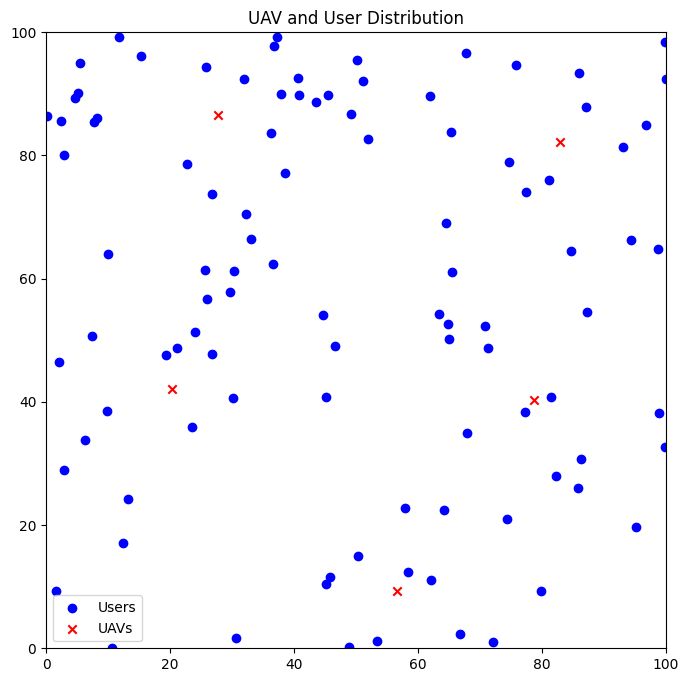

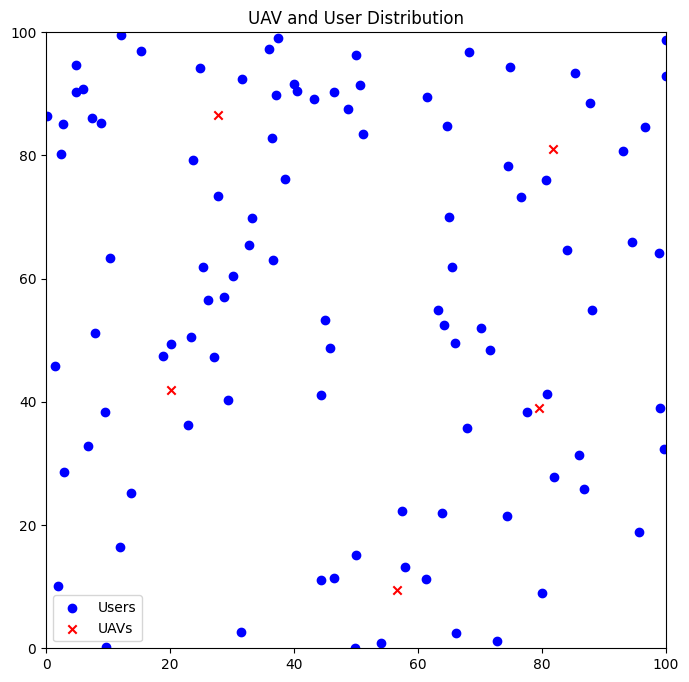

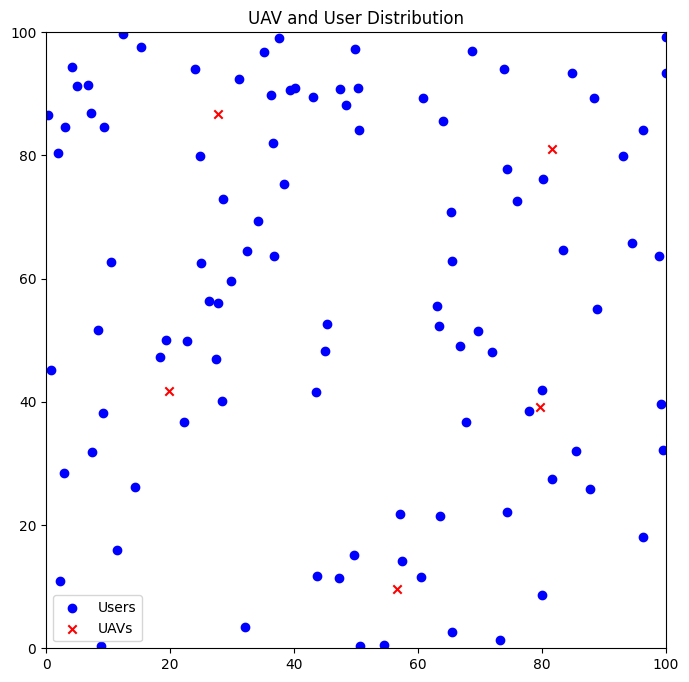

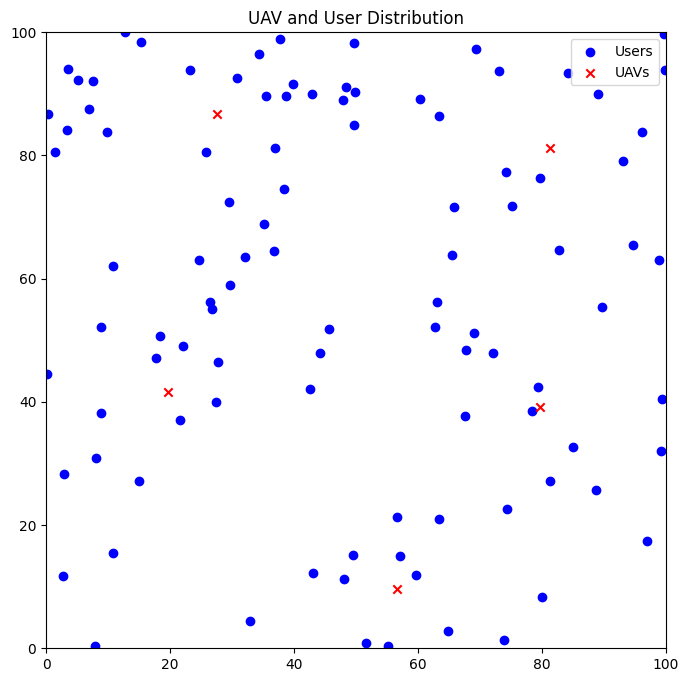

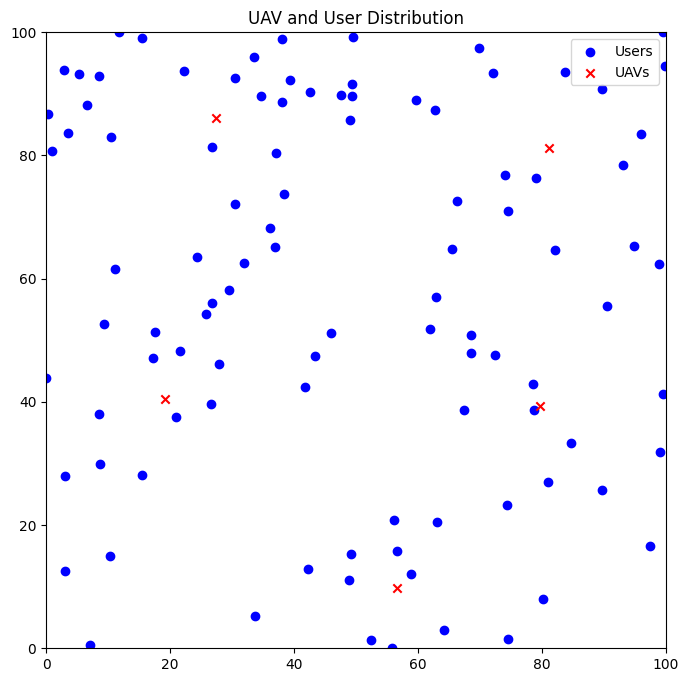

KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

In [28]:
# Test the trained agent
state = env.reset()
state = state.flatten()
for _ in range(100):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state.flatten()
    env.render()
    if done:
        break